link da aula: https://nbviewer.org/github/logictensornetworks/logictensornetworks/blob/master/tutorials/3-knowledgebase_and_learning.ipynb

In [10]:
import ltn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

Dois valores rotulados que é o: point_a e point_b. O resto não

seguem a seguinte regra

* A and B are mutually exclusive,
* any two close points should share the same label.

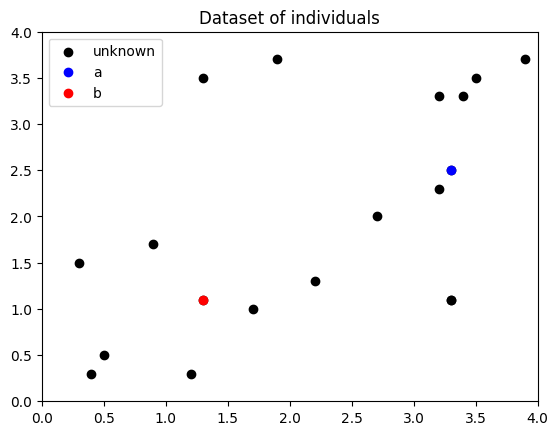

In [31]:
points = np.array(
        [[0.4,0.3],[1.2,0.3],[2.2,1.3],[1.7,1.0],[0.5,0.5],[0.3, 1.5],[1.3, 1.1],[0.9, 1.7],
        [3.4,3.3],[3.2,3.3],[3.2,2.3],[2.7,2.0],[3.5,3.5],[3.3, 2.5],[3.3, 1.1],[1.9, 3.7],[1.3, 3.5],[3.3, 1.1],[3.9, 3.7]])
point_a = [3.3,2.5]
point_b = [1.3,1.1]
fig, ax = plt.subplots()
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.scatter(points[:,0],points[:,1],color="black",label="unknown")
ax.scatter(point_a[0],point_a[1],color="blue",label="a")
ax.scatter(point_b[0],point_b[1],color="red",label="b")
ax.set_title("Dataset of individuals")
plt.legend();

Definimos a base de conhecimento K composto pelas seguintes regras da foto abaixo

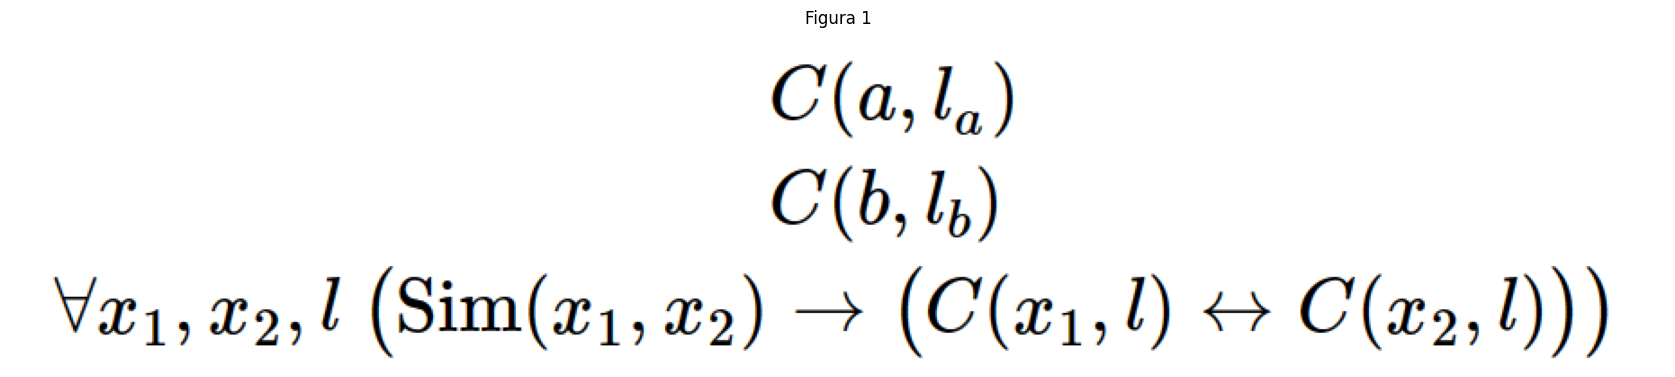

In [32]:
figura = plt.figure(figsize=(200,20))
regra = cv2.imread("./imagens/base de conhecimento K composto pelas seguintes regras.PNG")
plt.subplot(441), plt.title("Figura 1"), plt.axis('off'), plt.imshow(cv2.cvtColor(regra, cv2.COLOR_BGR2RGB))
plt.show()

Fazer explicação de a,b x1,x2,la, lb e l

In [33]:
x1 = ltn.Variable("x1",points)
x2 = ltn.Variable("x2",points)
a = ltn.Constant([3.3,2.5], trainable=False)
b = ltn.Constant([1.3,1.1], trainable=False)
l_a = ltn.Constant([1,0], trainable=False)
l_b = ltn.Constant([0,1], trainable=False)
l = ltn.Variable("l",[[1,0],[0,1]])

Sim = ltn.Predicate.Lambda(
    lambda args: tf.exp(-1.*tf.sqrt(tf.reduce_sum(tf.square(args[0]-args[1]),axis=1)))
)

fazer uma explicação como esse codigo abaixo funciona

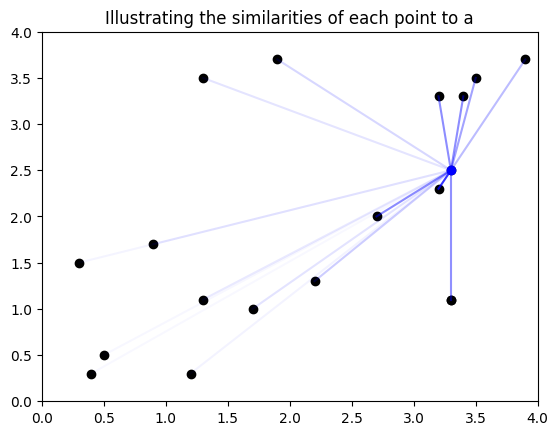

In [34]:
similarities_to_a = Sim([x1,a]).tensor
fig, ax = plt.subplots()
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.scatter(points[:,0],points[:,1],color="black")
ax.scatter(a.tensor[0],a.tensor[1],color="blue")
ax.set_title("Illustrating the similarities of each point to a")
for i, sim_to_a in enumerate(similarities_to_a):
    plt.plot([points[i,0],a.tensor[0]],[points[i,1],a.tensor[1]], alpha=sim_to_a.numpy(),color="blue")

Fazer explicação do que seria o modelo C (eu realmente não achei onde esse modelo foi usado)

In [35]:
class ModelC(tf.keras.Model):
    def __init__(self):
        super(ModelC, self).__init__()
        self.dense1 = tf.keras.layers.Dense(5, activation=tf.nn.elu)
        self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.elu)
        self.dense3 = tf.keras.layers.Dense(2, activation=tf.nn.softmax)

    def call(self, inputs):
        """inputs[0]: point, inputs[1]: onehot label"""
        x, label = inputs[0], inputs[1]
        x = self.dense1(x)
        x = self.dense2(x)
        prob = self.dense3(x)
        print("prob: ", prob, " | label: ", label)
        return tf.math.reduce_sum(prob*label,axis=1)

C = ltn.Predicate(ModelC())

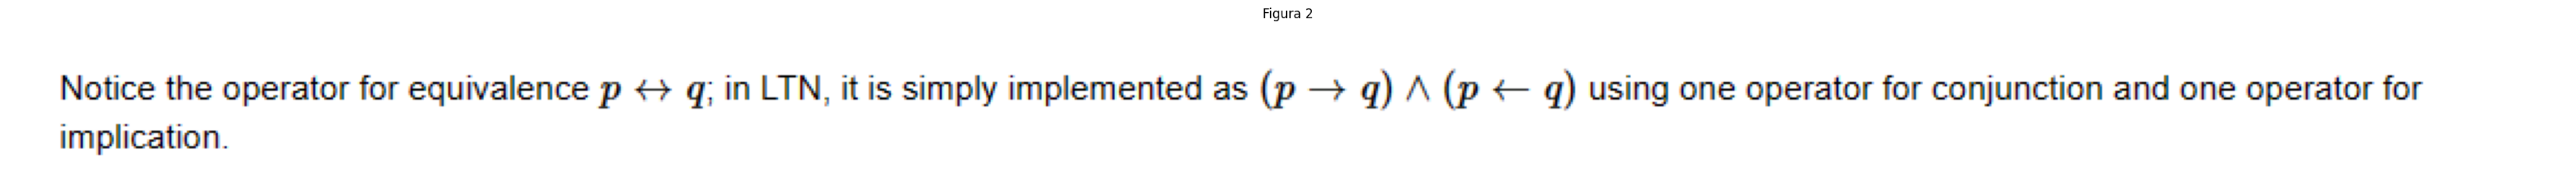

In [36]:
figura = plt.figure(figsize=(200,20))
regra = cv2.imread("./imagens/usando 2 operadores para mostar equivalencia.PNG")
plt.subplot(441), plt.title("Figura 2"), plt.axis('off'), plt.imshow(cv2.cvtColor(regra, cv2.COLOR_BGR2RGB))
plt.show()

adicionar os conectivos e os quantificadores

In [37]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Equiv = ltn.Wrapper_Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.And_Prod(),ltn.fuzzy_ops.Implies_Reichenbach()))
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(p=6),semantics="exists")

formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

agora iremos formalizar o que foi visto na Figura 1

In [38]:
@tf.function
def axioms():
    axioms = [
        C([a,l_a]),
        C([b,l_b]),
        Forall(
            [x1,x2,l],
            Implies( Sim([x1,x2]),
                    Equiv(C([x1,l]),C([x2,l]))
                   )
        )
    ]
    kb = formula_aggregator(axioms)
    sat = kb.tensor
    return sat

In [40]:
trainable_variables = C.trainable_variables
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in range(2000):
    with tf.GradientTape() as tape:
        loss = 1. - axioms()
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f"%(epoch, axioms()))
print("Training finished at Epoch %d with Sat Level %.3f"%(epoch, axioms()))

Epoch 0: Sat Level 0.426
Epoch 200: Sat Level 0.810
Epoch 400: Sat Level 0.945
Epoch 600: Sat Level 0.953
Epoch 800: Sat Level 0.954
Epoch 1000: Sat Level 0.954
Epoch 1200: Sat Level 0.955
Epoch 1400: Sat Level 0.955
Epoch 1600: Sat Level 0.955
Epoch 1800: Sat Level 0.955
Training finished at Epoch 1999 with Sat Level 0.955


prob:  tf.Tensor(
[[1.5058444e-05 9.9998498e-01]
 [3.5777030e-05 9.9996424e-01]
 [3.1445429e-02 9.6855462e-01]
 [2.8457528e-03 9.9715424e-01]
 [3.9752613e-05 9.9996030e-01]
 [4.5962930e-03 9.9540365e-01]
 [2.4419089e-03 9.9755812e-01]
 [2.7351556e-02 9.7264838e-01]
 [9.9960631e-01 3.9371388e-04]
 [9.9948406e-01 5.1586173e-04]
 [9.7326940e-01 2.6730601e-02]
 [7.5366294e-01 2.4633703e-01]
 [9.9981171e-01 1.8833163e-04]
 [9.9104005e-01 8.9599285e-03]
 [7.5650491e-02 9.2434955e-01]
 [9.9909246e-01 9.0759044e-04]
 [9.9555367e-01 4.4463491e-03]
 [7.5650491e-02 9.2434955e-01]
 [9.9993324e-01 6.6788394e-05]], shape=(19, 2), dtype=float32)  | label:  tf.Tensor(
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]], shape=(19, 2), dtype=float32)
prob:  tf.Tensor(
[[1.5058444e-05 9.9998498e-01]
 [3.5777030e-05 9.9996424e-01]
 [3.1445429e-02 9.6855462e-01]
 [2.8457528e-03 9.9715424

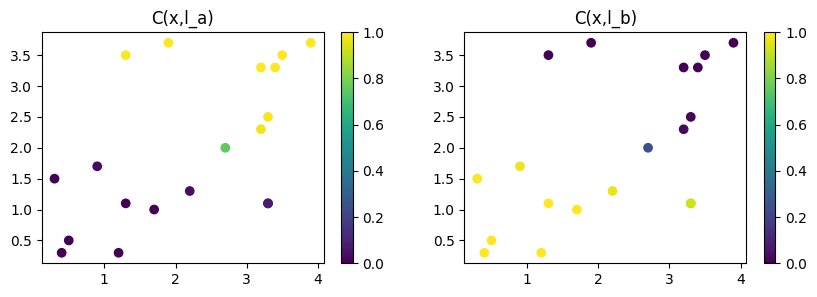

In [41]:
fig = plt.figure(figsize=(10,3))
fig.add_subplot(1,2,1)
is_a = C([x1,l_a])
plt.scatter(x1.tensor[:,0],x1.tensor[:,1],c=is_a.tensor.numpy(),vmin=0,vmax=1)
plt.title("C(x,l_a)")
plt.colorbar()
fig.add_subplot(1,2,2)
is_b = C([x1,l_b])
plt.scatter(x1.tensor[:,0],x1.tensor[:,1],c=is_b.tensor.numpy(),vmin=0,vmax=1)
plt.title("C(x,l_b)")
plt.colorbar()
plt.show();